# 2024 환경데이터 활용 및 분석 공모전 Jupyter Notebook

## 딥러닝 모델 학습 및 예측

### 목적
- 강릉 지점 ASOS(105)와 남대천 유량 관측 데이터를 활용하여 딥러닝 모델을 학습하고, 예측을 수행합니다
- 모델을 선정하는 과정은 학습을 계속 진행하며 장기 유출모의 예측 정확도(NSE)가 0.5이상의 Good 모델을 selection하는 절차를 거칩니다`(Kalin et al., 2010; An et al., 2023)`

### 결과
- 13번째 try에서 LSTM 모델이 0.51의 NSE를 기록하여 Good 모델로 선정됨

### 개선 가능한 점
- 전반적으로 상관관계가 좋지 않아 예측이 어려운 데이터셋임, 그래서 0.3이상의 변량 대신 모든 변량를 사용함

(3933, 30) (3933, 1) (1686, 30) (1686, 1)


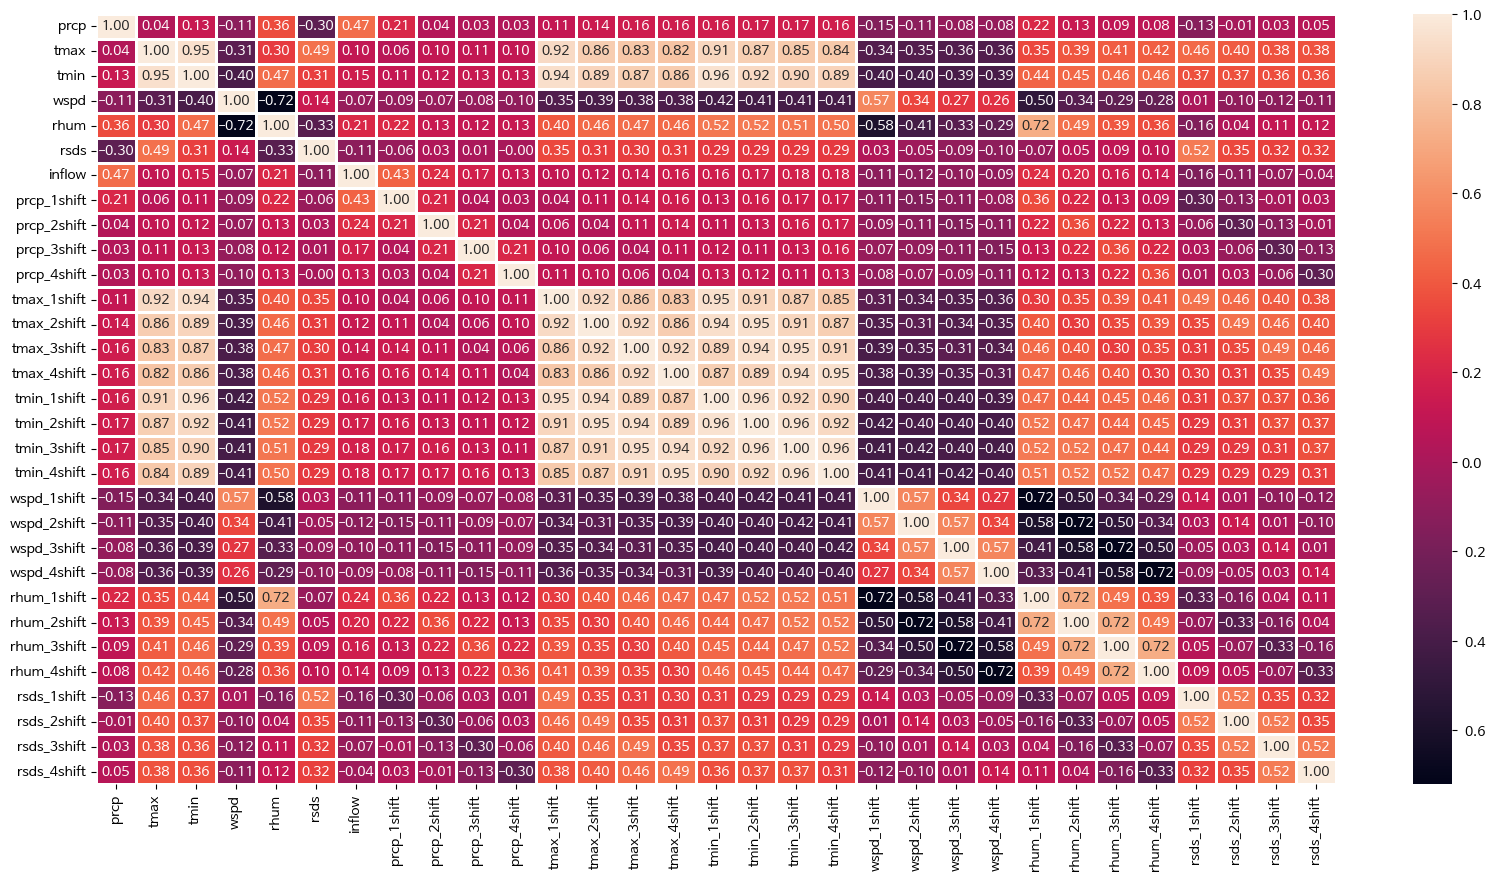

In [7]:
# 1. 기본 파라미터 정의
learning_rate = 0.001
batch_size = 30
epochs = 1000
hidden_size1 = 20
hidden_size2 = 10

# 2. 필요한 도구 호출, 도구 설정
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import r2_score

plt.rc("font", family="NanumBarunGothic")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
warnings.filterwarnings("ignore")
device = torch.device("cpu")

# 3. 데이터 불러오기

df_asos = pd.read_csv("/home/knu/바탕화면/SONmw/NSC/asos105.csv")
rawdata = pd.read_csv(
    "https://raw.githubusercontent.com/Alsdnworks/NDC/main/inflow_Hoesangyo_Bridge.csv"
)
GCM_data = pd.read_csv("/home/knu/바탕화면/SONmw/NSC/GCM_MEAN_105_Test_Data.csv")

GCM_data["date"] = pd.to_datetime(GCM_data["Unnamed: 0"])
GCM_data.drop("Unnamed: 0", axis=1, inplace=True)
GCM_data.index = GCM_data["date"]
GCM_data.drop("date", axis=1, inplace=True)
GCM_data

# 4. 데이터 전처리
target_column = "inflow"
ym = pd.DataFrame()
ym["date"] = pd.date_range(start="2009-01-01", end="2024-5-24", freq="D")
ym["date"] = pd.to_datetime(ym["date"])

# 유입량 데이터 전처리
rawdata["date"] = pd.to_datetime(rawdata["date"])
df_asos["X"] = pd.to_datetime(df_asos["X"])
rawdata.columns = ["date", "inflow"]
rawdata = pd.merge(ym, rawdata, how="left", left_on="date", right_on="date")
df_asos = pd.merge(ym, df_asos, how="left", left_on="date", right_on="X")
df_asos.head(50)

# ASOS 데이터 전처리
df_asos["date"] = pd.to_datetime(df_asos["X"])
df_asos.sort_values(by="date", inplace=True)
df_asos.fillna(method="bfill", inplace=True)

# 유입량과 ASOS 데이터를 합침
dataset = pd.merge(df_asos, rawdata, on="date", how="left")
dataset = pd.merge(ym, dataset, on="date", how="left")
dataset.index = dataset["date"]
dataset.drop("date", axis=1, inplace=True)
dataset.drop("X", axis=1, inplace=True)

if dataset.isna().sum().sum() != 0:
    print("데이터에 결측치가 있습니다.")
    raise ValueError

for c in dataset.columns:
    if c == "inflow":
        continue
    for i in range(4):
        dataset[f"{c}_{i+1}shift"] = dataset[c].shift(i + 1)

dataset_4EDA = dataset.copy()
plt.figure(figsize=(20, 10))
sns.heatmap(dataset_4EDA.corr(), annot=True, fmt=".2f", linewidths=2)
del dataset_4EDA

# 학습 데이터와 테스트 데이터로 분할
x = dataset.drop("inflow", axis=1)
y = dataset[["inflow"]]
input_size = x.shape[1]
output_size = y.shape[1]

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
scaler.fit(x)
y_scaler.fit(y)
x = x[4:]
y = y[4:]
x_train = train_test_split(x, test_size=0.3, shuffle=False)[0]
y_train = train_test_split(y, test_size=0.3, shuffle=False)[0]
x_val = train_test_split(x, test_size=0.3, shuffle=False)[1]
y_val = train_test_split(y, test_size=0.3, shuffle=False)[1]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(scaler.transform(x_train).astype(np.float32)),
        torch.tensor(y_scaler.transform(y_train).astype(np.float32)),
    ),
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(
        torch.tensor(scaler.transform(x_val).astype(np.float32)),
        torch.tensor(y_scaler.transform(y_val).astype(np.float32)),
    ),
    batch_size=batch_size,
    shuffle=False,
)



# 모델의 성능을 평가하기 위한 함수들


def calc_MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def calc_RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def calc_MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def calc_NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)


def calc_r2(y_true, y_pred):
    mean_t = np.mean(y_true)
    mean_p = np.mean(y_pred)
    return (
        1
        - (
            np.sum((y_true - mean_t) * (y_pred - mean_p))
            / np.sqrt(np.sum((y_true - mean_t) ** 2) * np.sum((y_pred - mean_p) ** 2))
        )
        ** 2
    )


def calc_pe(y_true, y_pred):
    return ((y_true - y_pred) / y_true) * 100


def calc_pbias(y_true, y_pred):
    return 100 * np.sum(y_true - y_pred) / np.sum(y_true)


def calc_rsr(y_true, y_pred):
    return np.sqrt(
        np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    )


def calc_mNSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)


def calc_md(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


def calc_rd(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_pred))


def calc_cp(y_true, y_pred):
    return 1 - (
        np.sum((y_true - y_pred) ** 2)
        / np.sum(
            (np.abs(y_true - np.mean(y_true)) + np.abs(y_pred - np.mean(y_pred))) ** 2
        )
    )


def calc_r(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sqrt(np.sum(y_true**2) * np.sum(y_pred**2))


def calc_bR2(y_true, y_pred):
    return 1 - (
        np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    )


def calc_rNSE(y_true, y_pred):
    return 1 - (
        np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    )


def calc_kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    return 1 - np.sqrt(
        (r - 1) ** 2
        + (np.std(y_pred) / np.std(y_true) - 1) ** 2
        + (np.mean(y_pred) / np.mean(y_true) - 1) ** 2
    )


def calc_ve(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)


def calc_all(y_true, y_pred):
    res_dict = {}
    res_dict["MAE"] = calc_MAE(y_true, y_pred)
    res_dict["RMSE"] = calc_RMSE(y_true, y_pred)
    res_dict["NSE"] = calc_NSE(y_true, y_pred)
    res_dict["r2"] = calc_r2(y_true, y_pred)
    res_dict["pbias"] = calc_pbias(y_true, y_pred)
    res_dict["rsr"] = calc_rsr(y_true, y_pred)
    res_dict["mNSE"] = calc_mNSE(y_true, y_pred)
    res_dict["md"] = calc_md(y_true, y_pred)
    res_dict["rd"] = calc_rd(y_true, y_pred)
    res_dict["cp"] = calc_cp(y_true, y_pred)
    res_dict["r"] = calc_r(y_true, y_pred)
    res_dict["bR2"] = calc_bR2(y_true, y_pred)
    res_dict["rNSE"] = calc_rNSE(y_true, y_pred)
    res_dict["kge"] = calc_kge(y_true, y_pred)
    res_dict["ve"] = calc_ve(y_true, y_pred)
    return res_dict

# 5. 딥러닝 모델 생성
# LSTM 모델 생성
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LSTM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.linear = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.linear(x[:, -1, :])
        return x


# BiLSTM 모델 생성
class BILSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(BILSTM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTM(
            input_size, hidden_size1, batch_first=True, bidirectional=True
        )
        self.lstm2 = nn.LSTM(
            hidden_size1 * 2, hidden_size2, batch_first=True, bidirectional=True
        )
        self.linear = nn.Linear(hidden_size2 * 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.linear(x[:, -1, :])
        return x


# GRU 모델 생성
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(GRU, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.linear = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x = self.linear(x[:, -1, :])
        return x


# 모델을 이용하여 학습을 위한 기능 제작


def train_model(
    model, optimizer, criterion, train_loader, val_loader, epochs, device, patience=50
):
    best_loss = float("inf")
    model.to(device)
    patience_count = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_count = 0
        else:
            patience_count += 1
            if patience_count > patience:
                model.load_state_dict(best_model)
                print("Early stopping")
                break

        print(
            f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}"
        )

    model.load_state_dict(best_model)
    return model



In [1]:

# 모델과 학습기를 이용한 학습
while True:
    modelBI = BILSTM(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = optim.Adam(modelBI.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    modelBI_t = train_model(
        modelBI, optimizer, criterion, train_loader, val_loader, epochs, device
    )

    modelLS = LSTM(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = optim.Adam(modelLS.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    modelLS_t = train_model(
        modelLS, optimizer, criterion, train_loader, val_loader, epochs, device
    )

    modelGR = GRU(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = optim.Adam(modelGR.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    modelGR_t = train_model(
        modelGR, optimizer, criterion, train_loader, val_loader, epochs, device
    )

    # Tensor를 일반 데이터로 변환 및 역정규화를 통해 실제값으로 변환
    modelBI.eval()
    modelLS.eval()
    modelGR.eval()
    test_results_BI = []
    test_results_LS = []
    test_results_GR = []
    for x, y in val_loader:
        x = x.to(device)
        test_results_BI.append(modelBI(x))
        test_results_LS.append(modelLS(x))
        test_results_GR.append(modelGR(x))
    test_results_BI = torch.cat(test_results_BI)
    test_results_LS = torch.cat(test_results_LS)
    test_results_GR = torch.cat(test_results_GR)
    test_results_BI = y_scaler.inverse_transform(test_results_BI.cpu().detach().numpy())
    test_results_LS = y_scaler.inverse_transform(test_results_LS.cpu().detach().numpy())
    test_results_GR = y_scaler.inverse_transform(test_results_GR.cpu().detach().numpy())
    x_train_tensor = torch.FloatTensor(scaler.transform(x_train)).to(device)
    train_results_BI = modelBI(x_train_tensor)
    train_results_LS = modelLS(x_train_tensor)
    train_results_GR = modelGR(x_train_tensor)
    train_results_BI = y_scaler.inverse_transform(train_results_BI.cpu().detach().numpy())
    train_results_LS = y_scaler.inverse_transform(train_results_LS.cpu().detach().numpy())
    train_results_GR = y_scaler.inverse_transform(train_results_GR.cpu().detach().numpy())

    # 학습 및 테스트 데이터의 예측값을 하나의 데이터로 합침
    results_BI = np.concatenate(
        (train_results_BI.flatten(), test_results_BI.flatten()), axis=0
    )
    results_LS = np.concatenate(
        (train_results_LS.flatten(), test_results_LS.flatten()), axis=0
    )
    results_GR = np.concatenate(
        (train_results_GR.flatten(), test_results_GR.flatten()), axis=0
    )

    # 결과를 데이터프레임(엑셀시트)으로 변환
    datares = pd.DataFrame()
    datares[target_column] = dataset[target_column][4:]

    datares["Inflow_BI-LSTM"] = results_BI
    datares["Inflow_LSTM"] = results_LS
    datares["Inflow_GRU"] = results_GR
    datares = datares.applymap(lambda x: x if x > 0 else 0)



    result_with_metric = {}
    result_with_metric["Inflow_BI-LSTM"] = calc_all(
        datares["inflow"], datares["Inflow_BI-LSTM"]
    )
    result_with_metric["Inflow_LSTM"] = calc_all(datares["inflow"], datares["Inflow_LSTM"])
    result_with_metric["Inflow_GRU"] = calc_all(datares["inflow"], datares["Inflow_GRU"])
    df_results = pd.DataFrame(result_with_metric)


    import os

    if os.path.exists("/home/knu/바탕화면/SONmw/NSC/try_count.txt"):
        with open("/home/knu/바탕화면/SONmw/NSC/try_count.txt", "r") as f:
            try_count = int(f.read())
        with open("/home/knu/바탕화면/SONmw/NSC/try_count.txt", "w") as f:
            f.write(str(try_count + 1))
    else:
        with open("/home/knu/바탕화면/SONmw/NSC/try_count.txt", "w") as f:
            f.write("1")
        try_count = 1            
    print(try_count)

    import joblib

    joblib.dump(modelBI_t, f"modelBI_{try_count}.pkl")
    joblib.dump(modelLS_t, f"modelLS_{try_count}.pkl")
    joblib.dump(modelGR_t, f"modelGR_{try_count}.pkl")
    joblib.dump(scaler, f"scaler_{try_count}.pkl")
    if df_results.T['NSE'].max() >= 0.5:
        print('성능이 좋은 모델이 있습니다.')
        print(df_results.T['NSE'].idxmax())
        print(df_results.T['NSE'].max())
        break


(3933, 30) (3933, 1) (1686, 30) (1686, 1)
Epoch 1/1000, Loss: 0.0040, Val Loss: 0.0016
Epoch 2/1000, Loss: 0.0031, Val Loss: 0.0015
Epoch 3/1000, Loss: 0.0028, Val Loss: 0.0011
Epoch 4/1000, Loss: 0.0030, Val Loss: 0.0033
Epoch 5/1000, Loss: 0.0025, Val Loss: 0.0020
Epoch 6/1000, Loss: 0.0022, Val Loss: 0.0014
Epoch 7/1000, Loss: 0.0022, Val Loss: 0.0013
Epoch 8/1000, Loss: 0.0022, Val Loss: 0.0014
Epoch 9/1000, Loss: 0.0021, Val Loss: 0.0019
Epoch 10/1000, Loss: 0.0020, Val Loss: 0.0013
Epoch 11/1000, Loss: 0.0021, Val Loss: 0.0016
Epoch 12/1000, Loss: 0.0021, Val Loss: 0.0017


In [2]:
df_results

Inflow_BI-LSTM  Inflow_LSTM  Inflow_GRU
MAE          8.621604     6.016609    5.417541
RMSE        17.460686    16.191097   16.878225
NSE          0.432821     0.512303    0.470031
r2           0.501124     0.487321    0.522274
pbias      -70.793337    -6.473862   30.898870
rsr          0.753113     0.698353    0.727990
mNSE         0.432821     0.512303    0.470031
md           1.318787     0.920319    0.828684
rd           0.772154     0.864361    1.199233
cp           0.812054     0.811343    0.782178
r            0.726114     0.740528    0.714228
bR2          0.432821     0.512303    0.470031
rNSE         0.432821     0.512303    0.470031
kge          0.222314     0.597719    0.459057
ve           0.567179     0.487697    0.529969

In [4]:
# 결과를 그래프로 시각화
import plotly.graph_objects as go
fig=go.Figure()
# set figure size
fig.update_layout(width=3000, height=1000)
#add pred data
#fig.add_trace(go.Scatter(x=datares.index, y=datares['Inflow_BI-LSTM'], mode='lines', name='Inflow_BI-LSTM', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=datares.index, y=datares['Inflow_LSTM'], mode='lines', name='Inflow_LSTM', line=dict(color='red')))
#fig.add_trace(go.Scatter(x=datares.index, y=datares['Inflow_GRU'], mode='lines', name='Inflow_GRU', line=dict(color='green')))
#add real data
fig.add_trace(go.Scatter(x=datares.index, y=datares['inflow'], mode='lines', name='Inflow', line=dict(color='black')))


## 2단계 GCM데이터 예측
### 목적
- GCM데이터를 활용하여 미래 유출량을 예측한다
- GCM데이터는 2011년 부터 2100년까지의 데이터를 사용한다
- 생산된 값은 단기, 중기, 장기 예측값으로 구분하며 각 단계는 30년의 기간을 의미한다.

In [61]:
#GCM예측 데이터 생산
GCM_dataset= GCM_data.copy()
for c in GCM_dataset.columns:
    for i in range(4):
        GCM_dataset[f"{c}_{i+1}shift"] = GCM_dataset[c].shift(i + 1)
GCM_dataset.dropna(inplace=True)
scaled_GCM_dataset=scaler.transform(GCM_dataset)
scaled_GCM_dataset_tensor=torch.FloatTensor(scaled_GCM_dataset).to(device)
modelLS.eval()
modelLS_results_GCM=modelLS(scaled_GCM_dataset_tensor)
modelLS_results_GCM=modelLS_results_GCM.cpu().detach().numpy()
modelLS_results_GCM=y_scaler.inverse_transform(modelLS_results_GCM)

#전체기간 그래프
import plotly.express as px 
gcm_df = pd.DataFrame(modelLS_results_GCM,columns=['Inflow'])
gcm_df['date']=GCM_data.index[4:]
fig = px.scatter(gcm_df, x='date', y='Inflow', trendline="ols", trendline_color_override='red')
fig.show()
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     162.3
Date:                Sun, 26 May 2024   Prob (F-statistic):           4.28e-37
Time:                        22:10:03   Log-Likelihood:            -1.0831e+05
No. Observations:               32868   AIC:                         2.166e+05
Df Residuals:                   32866   BIC:                         2.166e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1398      0.125     41.267      0.000       4.896       5.384
x1          5.597e-10   4.39e-11     12.741      0.000    4.74e-10    6.46e-10
==============================================================================
Omnibus:                    33106.059   Durbin-Watson:                   0.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2298446.363
Skew:                           4.961   Prob(JB):                         0.00
Kurtosis:                      42.748   Cond. No.                     9.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
baselineyear=2010
shortterm_TR=pd.DataFrame(pd.date_range(start=f"{baselineyear}-01-01", end=f"{baselineyear+30}-12-31", freq='D'),columns=['date'])
shortterm=pd.merge(shortterm_TR, gcm_df, how='left', on='date').dropna()
midterm_TR=pd.DataFrame(pd.date_range(start=shortterm_TR.iloc[-1].values[0]+pd.DateOffset(days=1), end=shortterm_TR.iloc[-1].values[0]+pd.DateOffset(years=30), freq='D'),columns=['date'])
midterm=pd.merge(midterm_TR, gcm_df, how='left', on='date')
longterm_TR=pd.DataFrame(pd.date_range(start=midterm_TR.iloc[-1].values[0]+pd.DateOffset(days=1), end=midterm_TR.iloc[-1].values[0]+pd.DateOffset(years=30), freq='D'),columns=['date'])
longterm=pd.merge(longterm_TR, gcm_df, how='left', on='date')

## 3단계 산불조심기간을 반영하여 목표 데이터 생산

In [79]:
#봄철 산불 조심 기간은 2. 1 ~ 5. 15
#가을철 산불 조심 기간은 11. 1. ~ 12. 15

spr=('02-01','05-15')
fall=('11-01','12-15')
def dataframe_cutter(rng, df):
    return df[(df['date'].dt.strftime('%m-%d')>=rng[0]) & (df['date'].dt.strftime('%m-%d')<=rng[1])].copy().reset_index(drop=True)
shortterm_spr=dataframe_cutter(spr, shortterm)
shortterm_fall=dataframe_cutter(fall, shortterm)
midterm_spr=dataframe_cutter(spr, midterm)
midterm_fall=dataframe_cutter(fall, midterm)
longterm_spr=dataframe_cutter(spr, longterm)
longterm_fall=dataframe_cutter(fall, longterm)

In [92]:
def stats(df, label):
    stats = []
    stats.append(df.groupby(df['date'].dt.year)['Inflow'].max().values)
    stats.append(df.groupby(df['date'].dt.year)['Inflow'].min().values)
    stats.append(df.groupby(df['date'].dt.year)['Inflow'].mean().values)
    stats.append(df.groupby(df['date'].dt.year)['Inflow'].median().values)
    stats.append(df.groupby(df['date'].dt.year)['Inflow'].sum().values)
    return pd.DataFrame(stats, index=['max', 'min', 'mean', 'median', 'sum'], columns=df['date'].dt.year.unique()).T
stf = stats(shortterm_fall, 'shortterm_fall')
mtf = stats(midterm_fall, 'midterm_fall')
ltf = stats(longterm_fall, 'longterm_fall')
sts = stats(shortterm_spr, 'shortterm_spr')
mts = stats(midterm_spr, 'midterm_spr')
lts = stats(longterm_spr, 'longterm_spr')

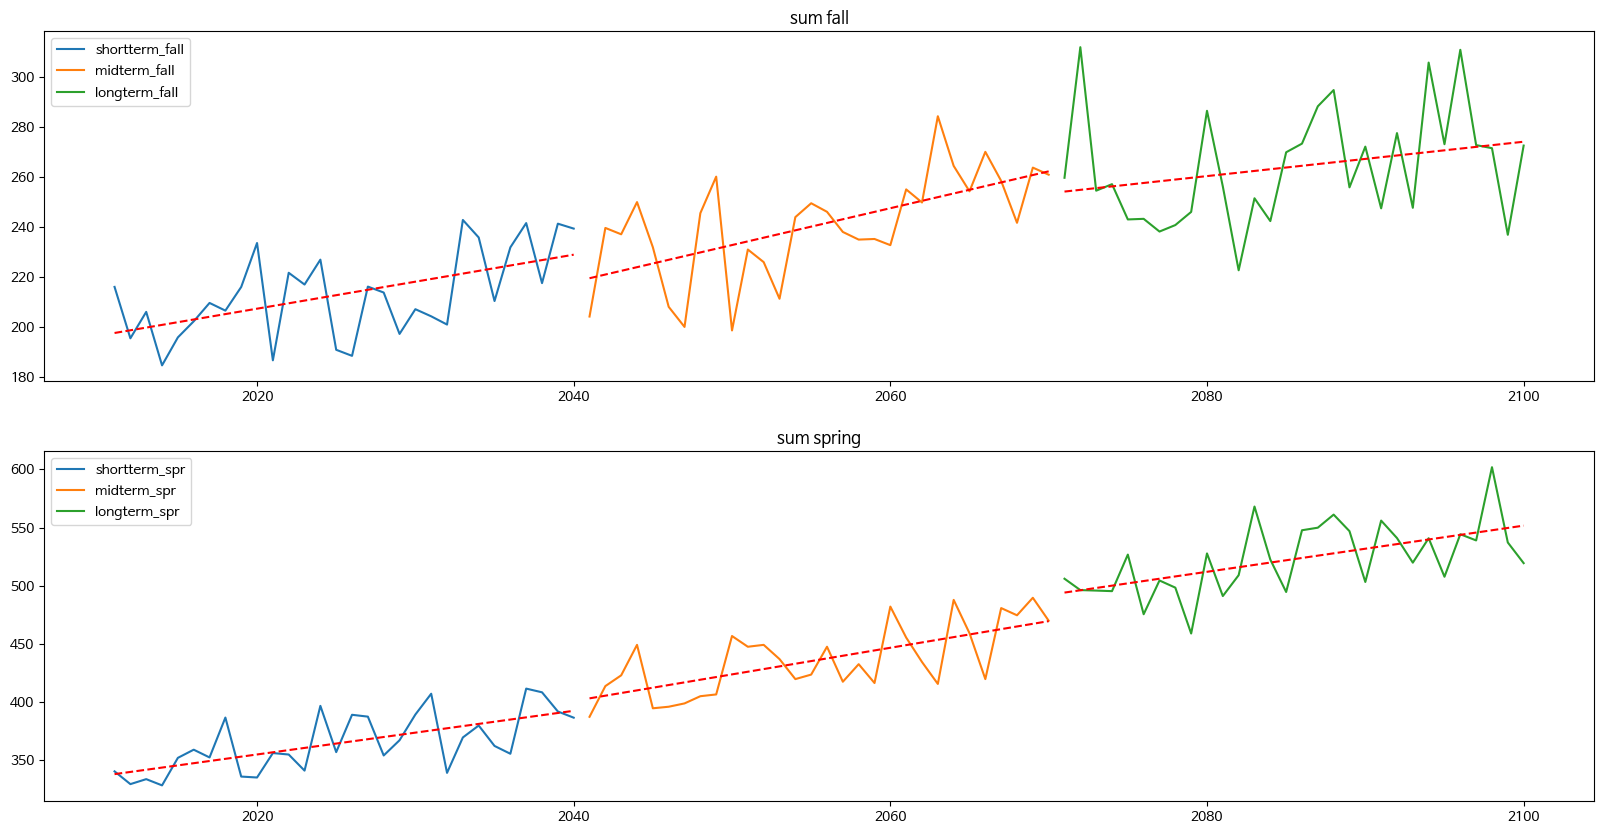

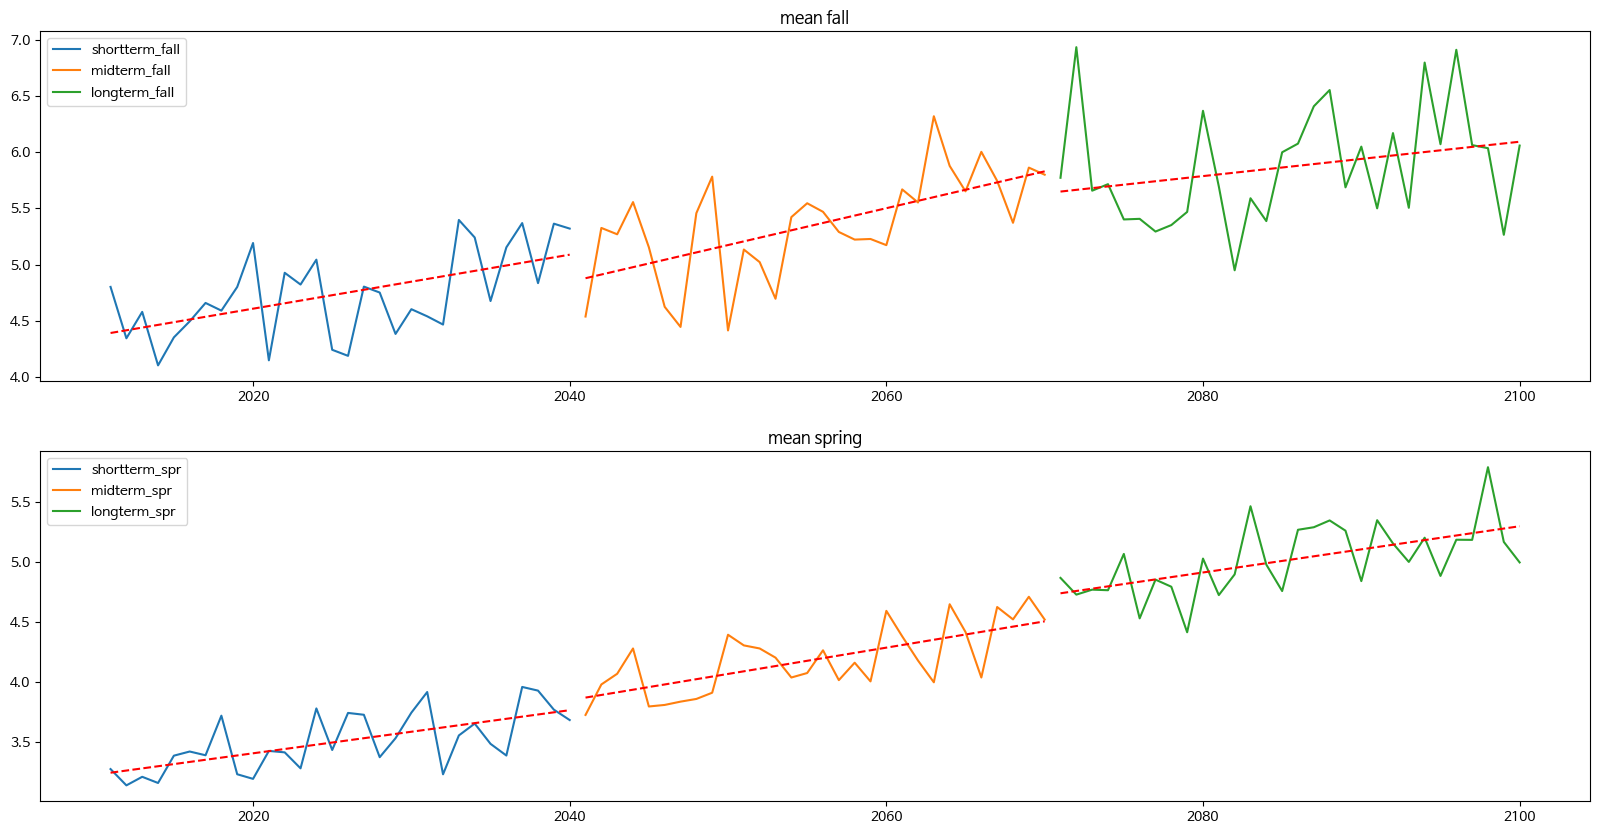

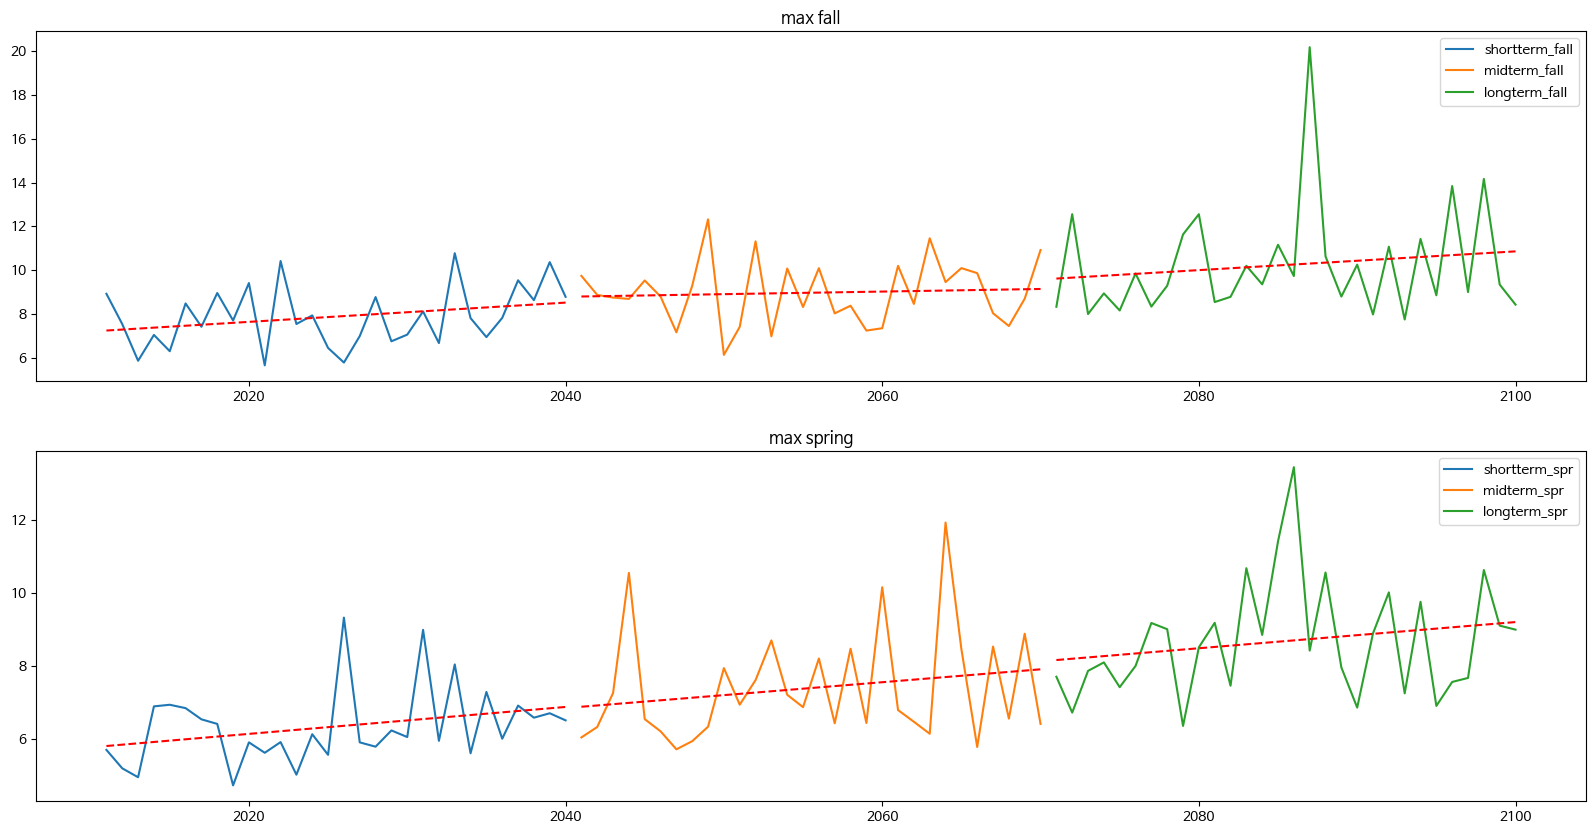

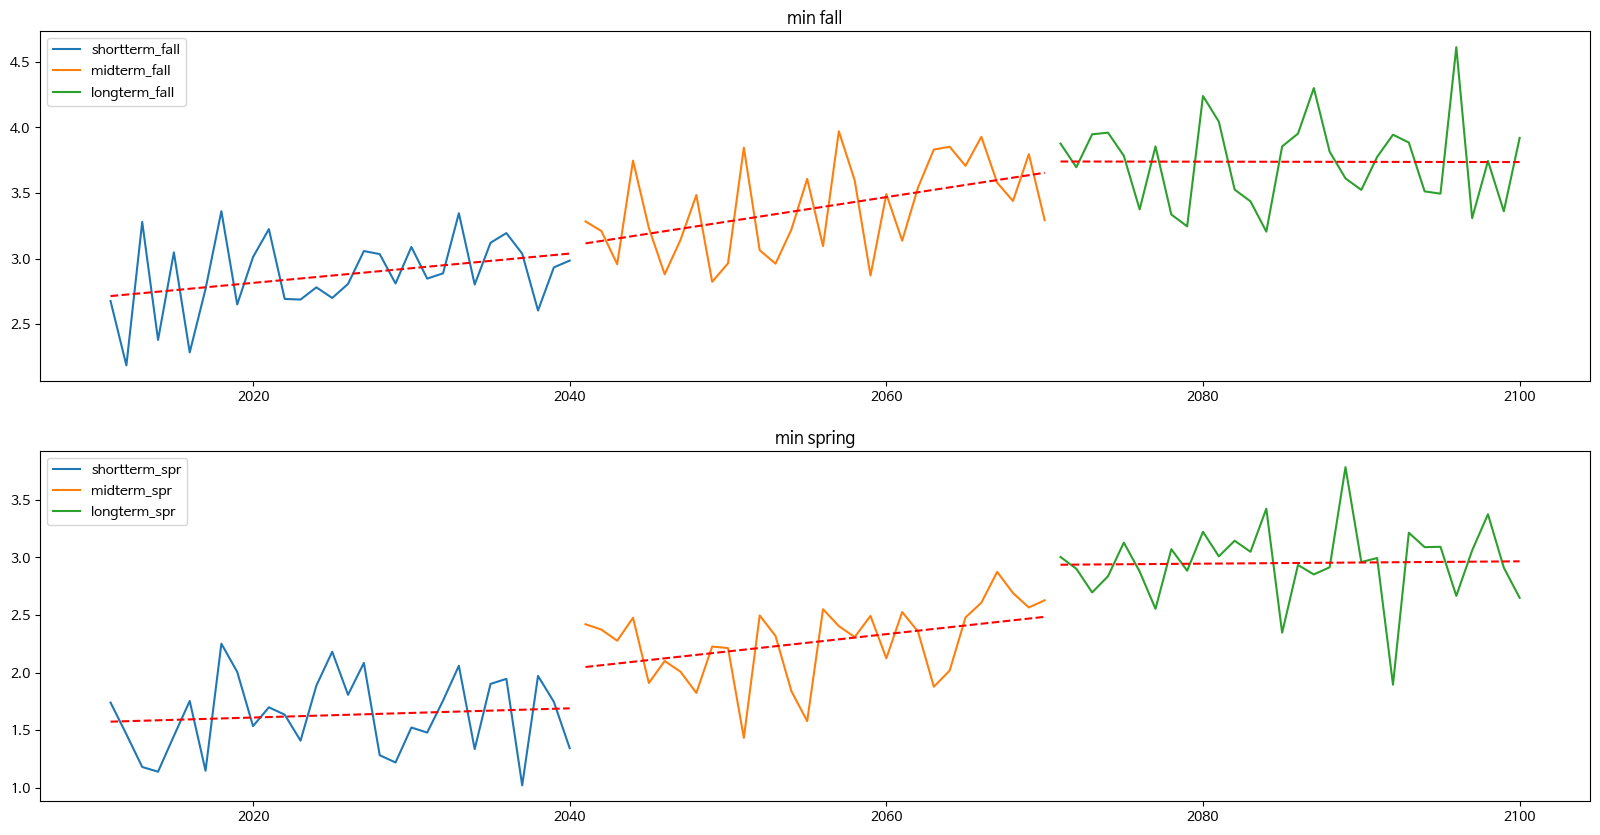

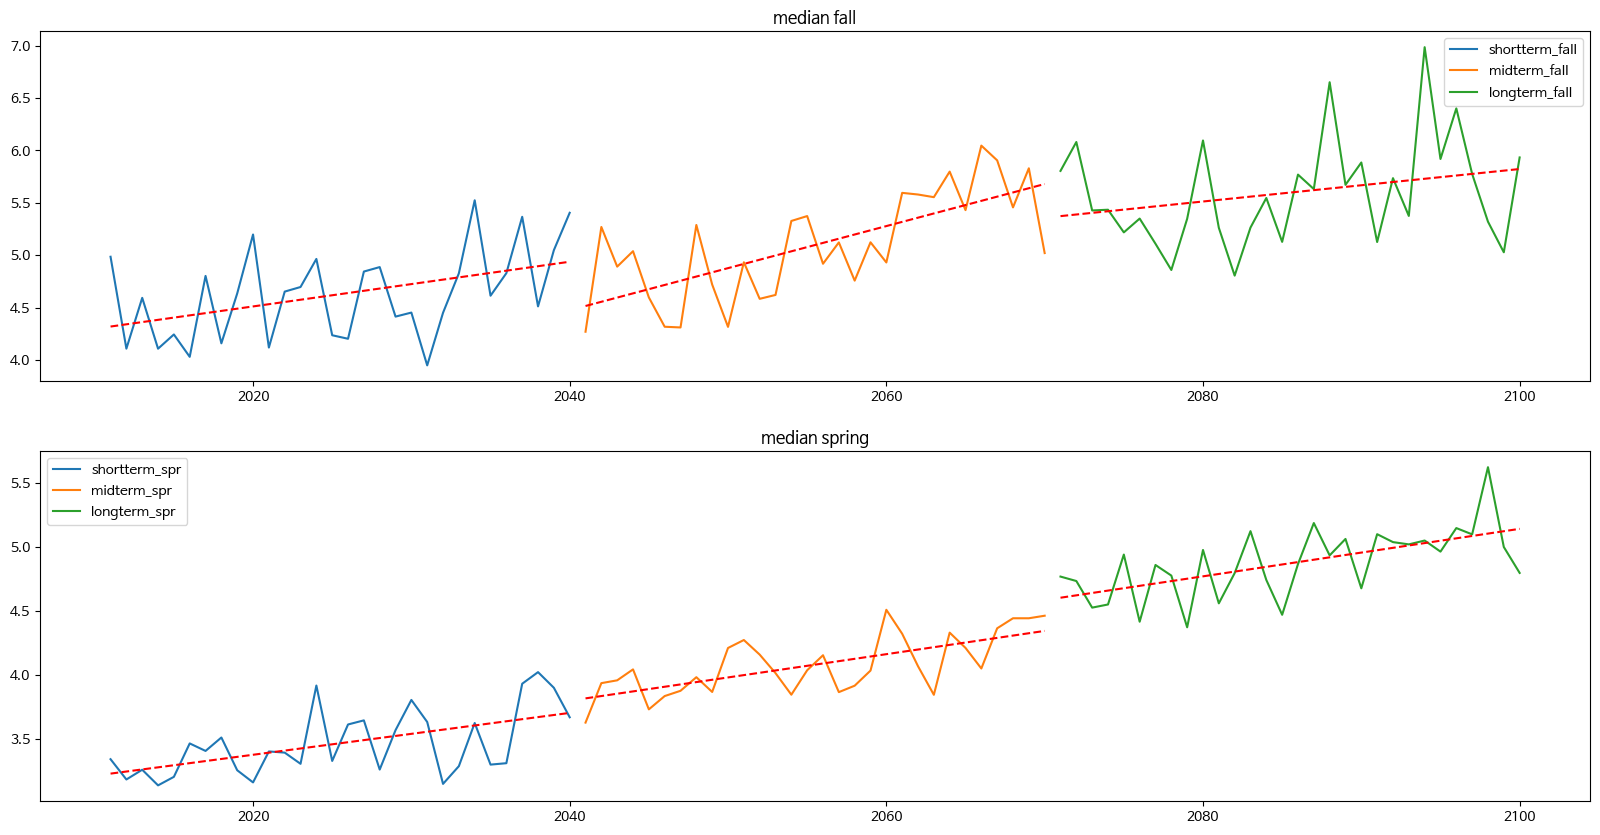

In [100]:
def pline(data,param):
    np.arange(data[param].shape[0]), np.poly1d(np.polyfit(np.arange(data[param].shape[0]), data[param].values, 1))(np.arange(data[param].shape[0]))
    return pd.DataFrame(np.poly1d(np.polyfit(np.arange(data[param].shape[0]), data[param].values, 1))(np.arange(data[param].shape[0])), index=data.index, columns=[param+'_trend'])
    
def plotter(param):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(stf[param], label='shortterm_fall')
    plt.plot(pline(stf, param)[param+'_trend'], 'r--')
    plt.plot(mtf[param], label='midterm_fall')
    plt.plot(pline(mtf, param)[param+'_trend'], 'r--')
    plt.plot(ltf[param], label='longterm_fall')
    plt.plot(pline(ltf, param)[param+'_trend'], 'r--')
    plt.title(f'{param} fall')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(sts[param], label='shortterm_spr')
    plt.plot(pline(sts, param)[param+'_trend'], 'r--')
    plt.plot(mts[param], label='midterm_spr')
    plt.plot(pline(mts, param)[param+'_trend'], 'r--')
    plt.plot(lts[param], label='longterm_spr')
    plt.plot(pline(lts, param)[param+'_trend'], 'r--')
    plt.title(f'{param} spring')
    plt.legend()
    
plotter('sum')
plotter('mean')
plotter('max')
plotter('min')
plotter('median')
plt.show()

In [8]:
GCM_data

prcp       tmax      tmin      wspd      rhum      rsds
date                                                                   
2011-01-01  1.948283   8.167849  0.417522  3.365969  0.470950  6.421356
2011-01-02  1.942854   7.888757 -1.730386  3.708748  0.494065  6.120088
2011-01-03  1.714599   4.757173 -3.233011  3.695413  0.487034  7.281174
2011-01-04  1.265526   5.175373 -2.702147  3.201294  0.554871  7.445937
2011-01-05  1.416911   6.901193 -3.053491  3.716985  0.504462  6.069521
...              ...        ...       ...       ...       ...       ...
2100-12-27  1.863569  12.565676  4.433082  2.605212  0.433331  7.608496
2100-12-28  3.191182  13.064659  4.356640  3.478043  0.486665  7.099413
2100-12-29  1.392619  11.928153  3.791902  4.080294  0.481789  7.644196
2100-12-30  1.677213  11.428683  4.054013  3.725207  0.500796  7.272466
2100-12-31  0.650234  12.611189  4.325767  3.409785  0.454436  7.843668

[32872 rows x 6 columns]

In [10]:
def calc_ffmc(temps,rhs,wss,rains,ffmc_olds,month,hourly=False):
    # FFMC 계산, 원본코드는 github에서 가져옴
    if type(temps) == type(np.array([0])):
        ffmc_out = np.zeros_like(temps) * np.nan # start ffmc off as being just nans
        mask, temps, rhs, wss, rains, ffmc_olds = mask_fields(temps, rhs, wss, rains, ffmc_olds, ignore={0:None, 1:None, 2:None, 3:0})
        wmo = 147.2*(101.-ffmc_olds)/(59.5+ffmc_olds)
        r = np.where(rains>0.5)
        ra = rains[r] - 0.5
        wmo_r = wmo[r]
        wmo_add = np.where(wmo_r>150.,
            42.5*ra*np.exp(-100.0/(251.-wmo_r))*(1.0-np.exp(-6.93/ra))+0.0015*(wmo_r-150.)*(wmo_r-150.)*np.sqrt(ra),
            42.5*ra*np.exp(-100.0/(251.-wmo_r))*(1.0-np.exp(-6.93/ra))
            )
        wmo_r+=wmo_add
        wmo[r]=wmo_r
        wmo = np.where(wmo>250.,250,wmo)
        ed=0.942 * rhs**0.679 + (11.0*np.exp((rhs-100.0)/10.0)) + 0.18 * (21.1-temps) * (1.0-1.0/np.exp(rhs*0.115))
        ew=0.618 * rhs**0.753 + (10.0*np.exp((rhs-100.0)/10.0)) + 0.18 * (21.1-temps) * (1.0-1.0/np.exp(rhs*0.115))
        wm=wmo
        r = np.where((wmo<ed) & (wmo<ew))
        r2 = np.where((wmo>ed))
        if len(r[0]>0):
            z = 0.424 * ( 1.0 - ((100.0-rhs[r])/100.0)**1.7 ) + 0.0694 * np.sqrt(wss[r]) * (1.0 - ((100.0-rhs[r])/100.0)**8.0 )
            if hourly:
                x = z * 0.0579 * np.exp(0.0365*temps[r])
                wm_r = ew[r] + (wmo[r]-ew[r]) * np.exp(-2.303*x)
            else:
                x = z * 0.581 * np.exp(0.0365*temps[r])
                wm_r = ew[r]-(ew[r]-wmo[r]) / (10.0**x)
            wm[r]=wm_r
        if len(r2[0]>0):
            z = 0.424 * ( 1.0 - (rhs[r2]/100.)**1.7 ) + 0.0694 * np.sqrt(wss[r2]) * ( 1 - (rhs[r2]/100.)**8.0 )
            if hourly:
                x = z * 0.0579 * np.exp(0.0365*temps[r2])
                wm_r2 = ed[r2] + ( wmo[r2] - ed[r2]) * np.exp(-2.303*x)
            else:
                x = z * 0.581 * np.exp(0.0365*temps[r2])
                wm_r2 = ed[r2] + ( wmo[r2] - ed[r2]) / (10.0**x)
            wm[r2]=wm_r2
        ffmcs = 59.5 * (250.0 - wm) / (147.2 + wm)
        ffmcs = np.where(ffmcs>101.0,101.0,ffmcs)
        ffmcs = np.where(ffmcs<0.,0.,ffmcs)
        ffmc_out[~mask] = ffmcs
        return ffmc_out
    else:
        wmo = 147.2*(101.-ffmc_olds)/(59.5+ffmc_olds)
        if rains>0.5:
            ra = rains - 0.5
            if wmo>150.: wmo_add = 42.5*ra*np.exp(-100.0/(251.-wmo))*(1.0-np.exp(-6.93/ra))+0.0015*(wmo-150.)*(wmo-150.)*np.sqrt(ra)
            else: wmo_add = 42.5*ra*np.exp(-100.0/(251.-wmo))*(1.0-np.exp(-6.93/ra))
            wmo+=wmo_add
        if wmo>250.: wmo = 250.
        ed=0.942 * rhs**0.679 + (11.0*np.exp((rhs-100.0)/10.0)) + 0.18 * (21.1-temps) * (1.0-1.0/np.exp(rhs*0.115))
        ew=0.618 * rhs**0.753 + (10.0*np.exp((rhs-100.0)/10.0)) + 0.18 * (21.1-temps) * (1.0-1.0/np.exp(rhs*0.115))
        wm=wmo
        if wmo<ed and wmo<ew:
            z = 0.424 * ( 1.0 - ((100.0-rhs)/100.0)**1.7 ) + 0.0694 * np.sqrt(wss) * (1.0 - ((100.0-rhs)/100.0)**8.0 )
            if hourly:
                x = z * 0.0579 * np.exp(0.0365*temps)
                wm = ew + (wmo-ew) * np.exp(-2.303*x)
            else:
                x = z * 0.581 * np.exp(0.0365*temps)
                wm = ew + (wmo-ew) / (10.0**x)
        elif wmo>ed:
            z = 0.424 * ( 1.0 - (rhs/100.)**1.7 ) + 0.0694 * np.sqrt(wss) * ( 1 - (rhs/100.)**8.0 )
            if hourly:
                x = z * 0.0579 * np.exp(0.0365*temps)
                wm = ed + ( wmo - ed) * np.exp(-2.303*x)
            else:
                x = z * 0.581 * np.exp(0.0365*temps)
                wm = ed + ( wmo - ed) / (10.0**x)
        ffmcs = 59.5 * (250.0 - wm) / (147.2 + wm)
        if ffmcs>101.0:    ffmcs = 101.0
        elif ffmcs<0.: ffmcs = 0.
        return ffmcs
            
def calc_ffmc_for_df(df):
    # FFMC 계산후 반영
    df=df.copy()
    df=df.reset_index(drop=True)
    df['MEAN_TA']=(df['tmax']+df['tmin'])/2
    df['HM']=df['rhum']*100
    df['FFMC']=0
    df.loc[0, 'FFMC']= calc_ffmc(df['MEAN_TA'][0],df['HM'][0],df['wspd'][0],df['prcp'][0],85,1).__round__(2)
    for i in range(1,len(df)):
        df.loc[i, 'FFMC'] = calc_ffmc(df.loc[i, 'MEAN_TA'], df.loc[i, 'HM'], df.loc[i, 'wspd'], df.loc[i, 'prcp'], df.loc[i-1, 'FFMC'],1).__round__(2)
    return df

In [11]:
ffmc_res=calc_ffmc_for_df(GCM_data)

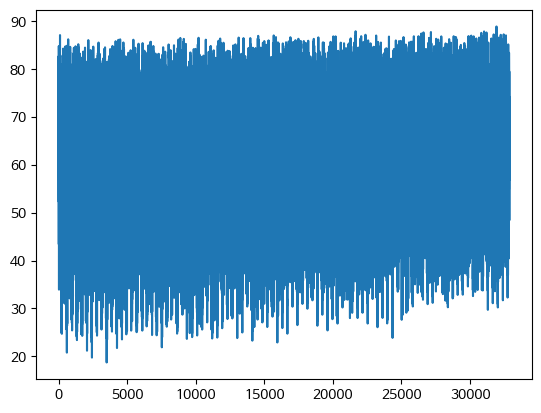

In [12]:
plt.plot(ffmc_res['FFMC'])

In [13]:
def pline(data,param):
    np.arange(data[param].shape[0]), np.poly1d(np.polyfit(np.arange(data[param].shape[0]), data[param].values, 1))(np.arange(data[param].shape[0]))
    return pd.DataFrame(np.poly1d(np.polyfit(np.arange(data[param].shape[0]), data[param].values, 1))(np.arange(data[param].shape[0])), index=data.index, columns=[param+'_trend'])

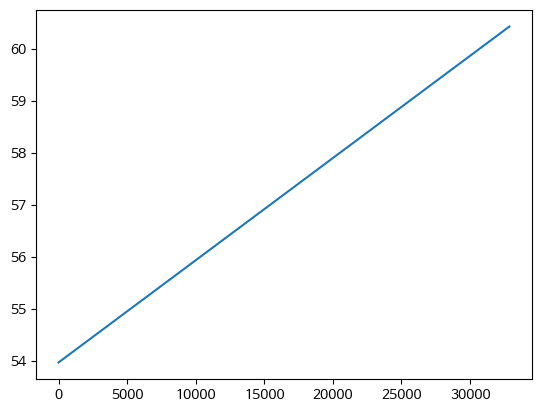

In [15]:
import matplotlib.pyplot as plt
plt.plot(pline(ffmc_res, 'FFMC')['FFMC_trend'])

In [16]:
pline(ffmc_res, 'FFMC')['FFMC_trend']

0        53.962740
1        53.962937
2        53.963134
3        53.963331
4        53.963528
           ...    
32867    60.435096
32868    60.435293
32869    60.435490
32870    60.435687
32871    60.435884
Name: FFMC_trend, Length: 32872, dtype: float64